In [268]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [269]:
from sympy import sqrt, cos, sin,  cosh,  sinh, Add
from sympy import Symbol, S, oo, Rational, Function, pi , factorial, O, symbols, lambdify, I
from sympy import Derivative, series, limit, Matrix, simplify, collect, solve, Poly, poly, diff, nsolve, transpose, factor_terms
from sympy import latex, init_printing
from sympy.core.numbers import NegativeOne, One, Zero
from sympy.printing.latex import print_latex

import numpy as np
from tqdm import tqdm
import ray
import time

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import HamDrift6D, HamQuad6D
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot
from acchamiltoniansandmatrices.Factorization.Factorization import truncate, taylorize, dragt_finn_factorization
from acchamiltoniansandmatrices.Utils.Polynomials import getpoly, RotationMatrix2D, explicitCheck, geteigenvects
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import RnpQuad6DChroma
from acchamiltoniansandmatrices.Matrices.SymbMatrices import RsymbQuad6DChroma
from acchamiltoniansandmatrices.Integrators import integrator

# Initialization - run once

In [3]:
%matplotlib notebook
init_printing() 
ray.init()

2021-03-20 10:58:20,829	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.38',
 'raylet_ip_address': '192.168.0.38',
 'redis_address': '192.168.0.38:6379',
 'object_store_address': '/tmp/ray/session_2021-03-20_10-58-20_230111_5240/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-20_10-58-20_230111_5240/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-03-20_10-58-20_230111_5240',
 'metrics_export_port': 58325,
 'node_id': '5ea6d4fcfccb95238bffc5d80cf4e3f1adb44f0b0577de617971b3be'}

# Symbolis and symbolic replacement lists

## Symbols

In [4]:
x, px, y, py, z, delta = symbols('x p_x y p_y z delta', real=True)
eps, h , k0, k1, k2, sigma, betag = symbols('epsilon h k_0 k_1 k_2 sigma beta_gamma', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)
x0,px0 = symbols('x_0 px_0') # to not overwrite anything

# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

## Replacements

In [5]:
# standardized substitutions that are useful - ORDER IN LISTS COUNTS !!!!
betagamma_rep = list(zip([beta0 * gamma0, beta0],[oo,1]))
series_rep    = list(zip([px,py,delta],[eps*px,eps*py,eps*delta]))
coord_rep     = list(zip([x,y],[eps*x,eps*y]))
thin_rep      = list(zip([px,py,delta],[0,0,0]))
xpx_rep       = list(zip([y,py,delta],[0,0,0]))
eps_rep       = list(zip([x,y,z,px,py,delta],[eps*x,eps*y,0,px*eps,py*eps,0]))
xyplane_rep   = list(zip([y,py,z,delta],[0,0,0,0]))
track_rep     = list(zip([x,px],[x0,px0]))
inv_track_rep = list(zip([x0,px0],[x,px]))

# Island settings for tracking

## Setup 1

In [6]:
#Island setting
_ld1 = 2.55
_ld2 = 2.35 #2.48
_lqf = 0.3
_lqd = 0.804
_k1  = 0.7
_k2  = - 0.35

repj = list(zip([LD,LD2,LQF,LQD,KQF,KQD,dld],[_ld1,_ld2,_lqf,_lqd,_k1,_k2,0]))

## Setup 2

In [7]:
#Island setting
_ld1 = 3.5805
_ld2 = 3.5805
_lqf = 0.342
_lqd = 0.668
_k1  = 0.49
_k2  = - 0.4999

rept = list(zip([LD,LD2,LQF,LQD,KQF,KQD,dld],[_ld1,_ld2,_lqf,_lqd,_k1,_k2,0]))

# Beam line definition

In [8]:
eldict = { 'drift' : 1, 'quad'  : 2, 'squad' : 25, 'sext'  : 3}

beamlines = [
    [eldict['quad'] , 4, LQF, KQF, 0],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQD, KQD, 0],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQF, KQF, 0],
]

# Functions

In [9]:
def AssignHam(element, order=3, length=1, k=1,flag=1):
    '''
    Element:
    1 = drift space
    2 = quadrupole
    25 = skew quadrupole
    3 = sextupole
    35 = skew sextupole - tbp
    '''
    order = order +1
 
    if element == 1:
        # drift hamiltonian
        H = NegativeOne() * HamDrift6D(beta0, gamma0, length,x,px,y,py,delta)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,0,n=order).removeO()
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))

        
    elif element == 2:
        # quadrupole - thin is set by flag
        H = NegativeOne() * HamQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
        
#         H = quad(order, length, strength, flag)
    elif element == 25:
        H = NegativeOne() *  HamSQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = skew_quad(order, length, strength, flag)
        
    elif element == 3:
        H = NegativeOne() *  HamSext6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)

    else:
        raise ValueError(element, ' no such reference in library.')      
    
    return H

In [10]:
def New_FIG(x,px,y,py,d2=False):
    fig = plt.figure(constrained_layout=True, figsize = (12,6))
    
    if d2:
        gs  = fig.add_gridspec(1, 2)
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax2.set_xlabel('$y$')
        ax2.set_ylabel('$p_y$')
        ax2.plot(y,py,'k.',alpha=.1, label='Exact')
    else:
        gs  = fig.add_gridspec(1, 1)
        ax1 = fig.add_subplot(gs[0,0])

    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p_x$')
    ax1.plot(x,px,'k.',alpha=.1, label='Exact')

In [50]:
def truncatexpx(func, order):
    _e = symbols('epsilon')
    func = func.subs(x0,_e*x0).subs(px0,_e*px0)
    func = func + O(_e**(order+1))
    return func.removeO().subs(_e,1)

In [295]:
def eom(ham,q_symbols,p_symbols):
    dq_dt_expr = Matrix([diff(ham, pi).simplify() for pi in p_symbols])
    dp_dt_expr = Matrix([-diff(ham, qi).simplify() for qi in q_symbols])
    
    dq_dt_func = lambdify([q_symbols,p_symbols], dq_dt_expr)
    dp_dt_func = lambdify([q_symbols,p_symbols], dp_dt_expr)
    
    return dq_dt_func, dp_dt_func

# Init coordinates to track

In [111]:
dpx = 0.0 # to get into islands

R0 = GenerateNDimCoordinateGrid(6,2,man_ranges={
    0:[1.0000e-06, 1.0000e-04, 1.0000e-02, 1.0000e+00, 2.5000e-01,
       3.5000e-01, 4.5000e-01, 5.5000e-01, 6.5000e-01, 8.0000e-01,
       9.0000e-01, 1.0000e+00, 1.1000e+00, 1.2000e+00, 1.3000e+00,
       1.4000e+00, 1.5000e+00, 1.6000e+00, 1.7000e+00, 1.8000e+00,
       1.8500e+00, 1.9000e+00, 1.9500e+00, 2.0000e+00, 2.0125e+00,
       2.0250e+00, 2.0500e+00, 2.1000e+00, 2.2000e+00, 2.3000e+00],
    1:[0,dpx],
    2:[0],
    3:[0],
    4:[0],
    5:[0]
})
r0 = R0.T.reshape(int(R0.size/6),6)

Shape: (6, 2, 30, 1, 1, 1, 1) - Number of paritcles: 60 


# Tracking Function

In [329]:
def track(r, fx,fpx):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    xn  = fx(_x,_px)
    pxn = fpx(_x,_px)
    
#     xn = xn + fpx(xn,_px)
#     pxn = pxn - fx(xn,_px)
    
    yn  = _y
    pyn = _py
    zn  = _z
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

# Element by Element Tracking

Here we track element by element using the individual Hamiltonians in the following way.
1. From the Hamiltonians the Taylor map to a given order is derived 
2. Taylor maps are applied sequentially in a symbolic way 
3. Final expression is an effective tracking map (non-symplectic)

## Assign Hamiltonians

In [492]:
HQF2 = AssignHam(*[eldict['quad'] , 4, LQF, KQF, 0])
HD_4 = AssignHam(*[eldict['drift'], 4, LD , Zero(), 0])
HQD2 = AssignHam(*[eldict['quad'] , 4, LQD, KQD, 0])

In [493]:
HQF2_op = LieOperator(HQF2.subs(xyplane_rep).expand().subs(rept),[x],[px])
HD_4_op = LieOperator(HD_4.subs(xyplane_rep).expand().subs(rept),[x],[px])
HQD2_op = LieOperator(HQD2.subs(xyplane_rep).expand().subs(rept),[x],[px])

In [494]:
HQF2_op.ham

## Build Taylor maps

In [495]:
taylor_qf2_x  =  HQF2_op.LieMap(x,2).ham
taylor_qf2_px =  HQF2_op.LieMap(px,2).ham

taylor_qf4_x  =  HQF2_op.LieMap(x,4).ham
taylor_qf4_px =  HQF2_op.LieMap(px,4).ham

taylor_d4_x   =  HD_4_op.LieMap(x,4).ham
taylor_d4_px  =  HD_4_op.LieMap(px,4).ham

taylor_qd2_x  =  HQD2_op.LieMap(x,2).ham
taylor_qd2_px =  HQD2_op.LieMap(px,2).ham

taylor_qd4_x  =  HQD2_op.LieMap(x,4).ham
taylor_qd4_px =  HQD2_op.LieMap(px,4).ham

100%|██████████| 3/3 [00:00<00:00, 481.35it/s]


In [498]:
taylor_qf2_x

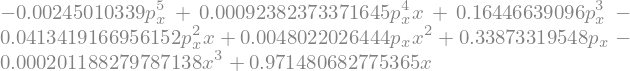

In [499]:
taylor_qf4_x

## Build effective Taylor

In [37]:
track_rep # used as dummies

In [539]:
truncate_bool  = True
truncate_order = 7
    

tic = time.perf_counter()
# QF
x1  = taylor_qf4_x.subs(track_rep).subs(rept).expand() 
px1 = taylor_qf4_px.subs(track_rep).subs(rept).expand()

if truncate_bool:
    x1 = truncatexpx(x1,truncate_order)
    px1 = truncatexpx(px1,truncate_order)

# QF - D
x2  = taylor_d4_x.subs(list(zip([x,px],[x1,px1]))).subs(rept).expand()
px2 = taylor_d4_px.subs(list(zip([x,px],[x1,px1]))).subs(rept).expand()

if truncate_bool:
    x2 = truncatexpx(x2,truncate_order)
    px2 = truncatexpx(px2,truncate_order)

# QF - D - QD 
x3  = taylor_qd4_x.subs(list(zip([x,px],[x2,px2]))).subs(rept).expand()
px3 = taylor_qd4_px.subs(list(zip([x,px],[x2,px2]))).subs(rept).expand()

if truncate_bool:
    x3 = truncatexpx(x3,truncate_order)
    px3 = truncatexpx(px3,truncate_order)

# QF - D - QD - D
x4  = taylor_d4_x.subs(list(zip([x,px],[x3,px3]))).subs(rept).expand()
px4 = taylor_d4_px.subs(list(zip([x,px],[x3,px3]))).subs(rept).expand()

if truncate_bool:
    x4 = truncatexpx(x4,truncate_order)
    px4 = truncatexpx(px4,truncate_order)

# QF - D - QD - D - QF
x5  = taylor_qf4_x.subs(list(zip([x,px],[x4,px4]))).subs(rept).expand()
px5 = taylor_qf4_px.subs(list(zip([x,px],[x4,px4]))).subs(rept).expand()

if truncate_bool:
    x5 = truncatexpx(x5,truncate_order)
    px5 = truncatexpx(px5,truncate_order)

print("took {}".format(time.perf_counter()-tic))

took 2.117996630999187


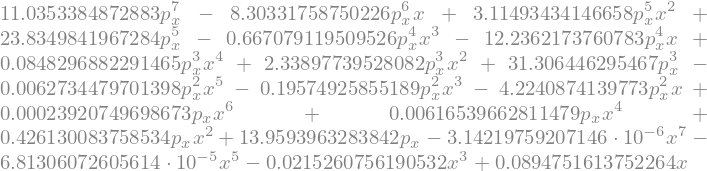

In [540]:
x5.subs(inv_track_rep)

In [541]:
# generate tracking maps for non-symplectic taylor
tic = time.perf_counter()

x5expanded  =  x5.subs(inv_track_rep)
px5expanded = px5.subs(rept).subs(inv_track_rep).expand()

a = LieOperator(x5expanded,[x],[px])
b = LieOperator(px5expanded,[x],[px])

fxt2  = truncate(a,20)
fpxt2 = truncate(b,20)

ffxt2 = lambdify((x,px),fxt2)
ffpxt2 = lambdify((x,px),fpxt2)

print("took {}".format(time.perf_counter()-tic))

took 0.15651836299912247


## Build symplectic Taylor (order 1 symplectic integrator)

In [554]:
dqt1_expr = diff(HQF2.subs(xyplane_rep).expand().subs(rept),px)
dpt1_expr = -diff(HQF2.subs(xyplane_rep).expand().subs(rept),x) # minyus sign !!!

dqt2_expr = diff(HD_4.subs(xyplane_rep).expand().subs(rept),px)
dpt2_expr = -diff(HD_4.subs(xyplane_rep).expand().subs(rept),x) # minyus sign !!!

dqt3_expr = diff(HQD2.subs(xyplane_rep).expand().subs(rept),px)
dpt3_expr = -diff(HQD2.subs(xyplane_rep).expand().subs(rept),x) # minyus sign !!!

In [557]:
dqt1 = lambdify((x,px),dqt1_expr)
dpt1 = lambdify((x,px),dpt1_expr) # minyus sign !!!

dqt2 = lambdify((x,px),dqt2_expr)
dpt2 = lambdify((x,px),dpt2_expr) # minyus sign !!!

dqt3 = lambdify((x,px),dqt3_expr)
dpt3 = lambdify((x,px),dpt3_expr) # minyus sign !!!

In [555]:
xx1_expr = x  + dqt1_expr
px1_expr = px + dpt1_expr.subs(x,xx1_expr)

xx2_expr = xx1_expr  + dqt2_expr
px2_expr = px1_expr  + dpt2_expr.subs(x,xx2_expr)

xx3_expr = xx2_expr  + dqt3_expr
px3_expr = px2_expr  + dpt3_expr.subs(x,xx3_expr)

xx4_expr = xx3_expr  + dqt2_expr
px4_expr = px3_expr  + dpt2_expr.subs(x,xx4_expr)

xx5_expr = xx4_expr  + dqt1_expr
px5_expr = px4_expr  + dpt1_expr.subs(x,xx5_expr)

xx5_expr, px5_expr

## Tracking

In [558]:
def track_symplectic(r):
    __x = r[:,0]
    _px = r[:,1]
    __y = r[:,2]
    _py = r[:,3]
    __z = r[:,4]
    _pz = r[:,5]
    
    xx1  = __x + dqt1(__x,_px)
    px_1 = _px + dpt1(xx1,_px)
    
    xx2  = xx1  + dqt2(xx1,px_1)
    px_2 = px_1 + dpt2(xx2,px_1)
    
    xx3  = xx2  + dqt3(xx2,px_2)
    px_3 = px_2 + dpt3(xx3,px_2)
    
    xx4  = xx3  + dqt2(xx3,px_3)
    px_4 = px_3 + dpt2(xx4,px_3)
    
    xx5  = xx4  + dqt1(xx4,px_4)
    px_5 = px_4 + dpt1(xx5,px_4)
    
    return np.array([xx5, px_5, __y, _py, __z, _pz]).transpose()

In [970]:
X_ElByEl_2_4_2 = np.array([r0])
X_ElByEl_2_4_2_symplectic = np.array([r0])

duration = 350

for i in tqdm(range(1, duration + 1)): 
    r_2      = track(X_ElByEl_2_4_2[-1],ffxt2,ffpxt2)
    r_2_symp = track_symplectic(X_ElByEl_2_4_2_symplectic[-1])
    
    X_ElByEl_2_4_2 = np.append(X_ElByEl_2_4_2, [r_2], axis = 0)
    X_ElByEl_2_4_2_symplectic= np.append(X_ElByEl_2_4_2_symplectic, [r_2_symp], axis = 0)

100%|██████████| 350/350 [00:00<00:00, 1198.03it/s]


<IPython.core.display.Javascript object>


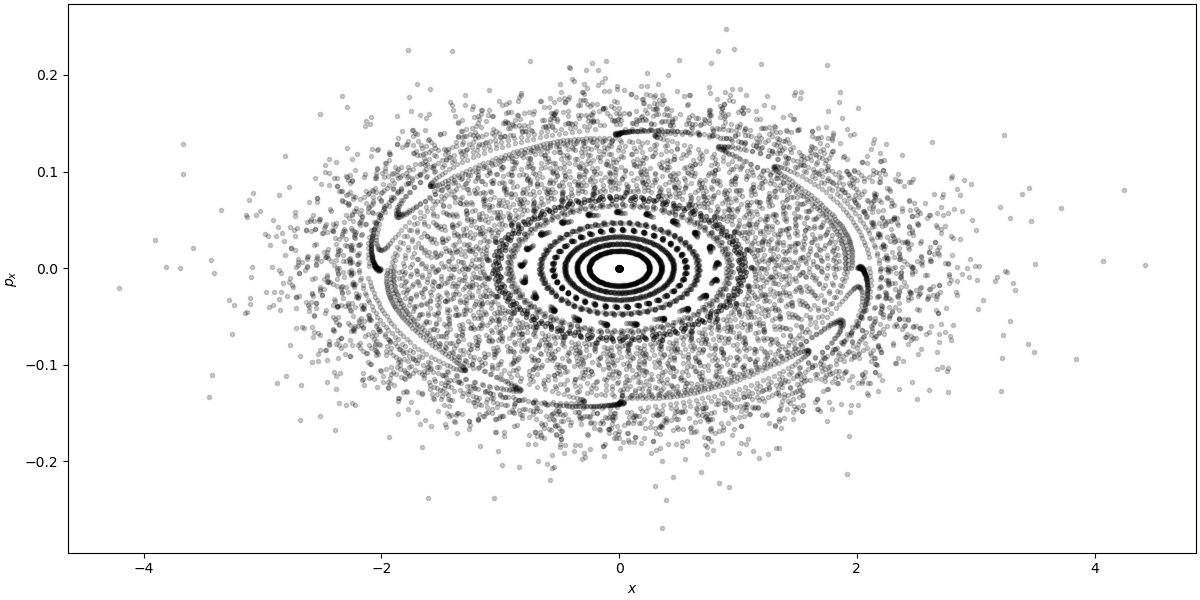

<IPython.core.display.Javascript object>


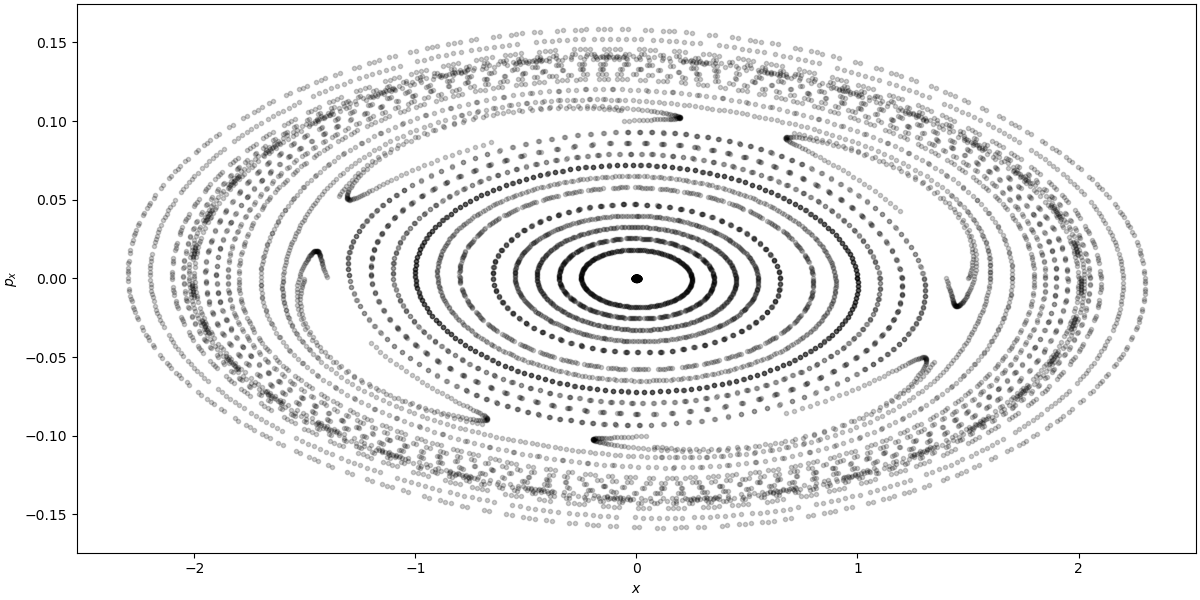

In [971]:
X_ElByEl_2_4_2_array = np.array(X_ElByEl_2_4_2)
X_ElByEl_2_4_2_symplectic_array = np.array(X_ElByEl_2_4_2_symplectic)

New_FIG(X_ElByEl_2_4_2_array[:,:,0],X_ElByEl_2_4_2_array[:,:,1],X_ElByEl_2_4_2_array[:,:,2],X_ElByEl_2_4_2_array[:,:,3])
New_FIG(X_ElByEl_2_4_2_symplectic_array[:,:,0],X_ElByEl_2_4_2_symplectic_array[:,:,1],X_ElByEl_2_4_2_symplectic_array[:,:,2],X_ElByEl_2_4_2_symplectic_array[:,:,3])

# Dragt-Finn

## Non-Symplectic Taylor

In [564]:
truncatexpx(x5,2).subs(inv_track_rep)

In [962]:
DF = dragt_finn_factorization(
    [
        truncatexpx(x5,5).subs(inv_track_rep), 
        truncatexpx(px5,5).subs(inv_track_rep),
        y,
        py,
        z,
        delta]
    ,
    [x,px,y,py,z,delta]
)

2021-03-20 18:21:15,681 - root -INFO - Starting dragt-finn factorization.
2021-03-20 18:21:15,694 - root -INFO - Taylor in
2021-03-20 18:21:15,697 - root -INFO - [23.8349841967284*p_x**5 - 12.2362173760783*p_x**4*x + 2.33897739528082*p_x**3*x**2 + 31.306446295467*p_x**3 - 0.19574925855189*p_x**2*x**3 - 4.2240874139773*p_x**2*x + 0.00616539662811479*p_x*x**4 + 0.426130083758534*p_x*x**2 + 13.9593963283842*p_x - 6.81306072605614e-5*x**5 - 0.0215260756190532*x**3 + 0.0894751613752264*x, -4.11509132797526*p_x**5 + 2.06235391824166*p_x**4*x - 0.388404185691725*p_x**3*x**2 - 4.55012938075029*p_x**3 + 0.0318771403406565*p_x**2*x**3 + 0.364771579882123*p_x**2*x - 0.000965195273812563*p_x*x**4 - 0.0166394023432772*p_x*x**2 + 0.0894751613752263*p_x + 1.02692019603413e-5*x**5 + 0.000524983669484488*x**3 - 0.0710738086004275*x, y, p_y, z, delta]
2021-03-20 18:21:15,736 - root -INFO - Transforming Taylor to Lie.
2021-03-20 18:21:15,739 - root -INFO - [23.8349841967284*p_x**5 - 12.2362173760783*p_x*

100%|██████████| 3/3 [00:00<00:00, 641.82it/s]


2021-03-20 18:21:16,279 - root -INFO - Taylor out
2021-03-20 18:21:16,287 - root -INFO - [61.6146236471489*p_x**5 + 22.4272517358344*p_x**4*x + 2.80148063488547*p_x**3*x**2 + 66.4488561699696*p_x**3 + 0.131112230033233*p_x**2*x**3 + 5.47846645637996*p_x**2*x + 0.00272816739525554*p_x*x**4 + 0.267249391561194*p_x*x**2 + 2.13162235195751e-5*x**5 + 0.00955334494216072*x**3, -9.4657463495927*p_x**5 - 3.56759787396547*p_x**4*x - 0.460877893904997*p_x**3*x**2 - 1.76138957192678*p_x**3 - 0.0219565046582787*p_x**2*x**3 - 0.271417210120626*p_x**2*x - 0.000464413373393456*p_x*x**4 - 0.0286972359738208*p_x*x**2 - 3.75701283192046e-6*x**5 - 0.0014771676430734*x**3 - 9.10729824887824e-17*x, 0, 0, 0, 0]
2021-03-20 18:21:16,303 - root -INFO - Taylor in
2021-03-20 18:21:16,304 - root -INFO - [61.6146236471489*p_x**5 + 22.4272517358344*p_x**4*x + 2.80148063488547*p_x**3*x**2 + 66.4488561699696*p_x**3 + 0.131112230033233*p_x**2*x**3 + 5.47846645637996*p_x**2*x + 0.00272816739525554*p_x*x**4 + 0.26724939

100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


2021-03-20 18:21:17,972 - root -INFO - Taylor out
2021-03-20 18:21:17,973 - root -INFO - [61.6146236471489*p_x**5 + 26.3041941409018*p_x**4*x + 4.21786822451139*p_x**3*x**2 + 0.29497294158045*p_x**2*x**3 + 0.00826765515511638*p_x*x**4 + 8.18027010663383e-5*x**5 - x, -5.58880394452529*p_x**5 - 2.15121028433955*p_x**4*x - 0.29701718235778*p_x**3*x**2 + 0.0647659135332088*p_x**3 - 0.0164170168984179*p_x**2*x**3 - 0.00416781855943266*p_x**2*x - 0.000403926895846693*p_x*x**4 - 3.72011473386245e-5*p_x*x**2 - p_x - 3.75701283192046e-6*x**5 - 9.10729824887824e-17*x, -y, -p_y, -z, -delta]
2021-03-20 18:21:17,995 - root -INFO - Taylor in
2021-03-20 18:21:18,001 - root -INFO - [61.6146236471489*p_x**5 + 26.3041941409018*p_x**4*x + 4.21786822451139*p_x**3*x**2 + 0.29497294158045*p_x**2*x**3 + 0.00826765515511638*p_x*x**4 + 8.18027010663383e-5*x**5 - x, -5.58880394452529*p_x**5 - 2.15121028433955*p_x**4*x - 0.29701718235778*p_x**3*x**2 + 0.0647659135332088*p_x**3 - 0.0164170168984179*p_x**2*x**3 - 

100%|██████████| 3/3 [00:00<00:00, 903.10it/s]


2021-03-20 18:21:18,120 - root -INFO - Taylor out
2021-03-20 18:21:18,123 - root -INFO - [61.6146236471489*p_x**5 + 26.3041941409018*p_x**4*x + 4.21786822451139*p_x**3*x**2 + 0.29497294158045*p_x**2*x**3 + 0.00826765515511638*p_x*x**4 + 8.18027010663383e-5*x**5 - 2*x, -5.58880394452529*p_x**5 - 2.15121028433955*p_x**4*x - 0.29701718235778*p_x**3*x**2 + 0.0647659135332088*p_x**3 - 0.0164170168984179*p_x**2*x**3 - 0.00416781855943266*p_x**2*x - 0.000403926895846693*p_x*x**4 - 3.72011473386245e-5*p_x*x**2 - 2*p_x - 3.75701283192046e-6*x**5 - 9.10729824887824e-17*x, -2*y, -2*p_y, -2*z, -2*delta]
2021-03-20 18:21:18,147 - root -INFO - Taylor in
2021-03-20 18:21:18,149 - root -INFO - [61.6146236471489*p_x**5 + 26.3041941409018*p_x**4*x + 4.21786822451139*p_x**3*x**2 + 0.29497294158045*p_x**2*x**3 + 0.00826765515511638*p_x*x**4 + 8.18027010663383e-5*x**5 - 2*x, -5.58880394452529*p_x**5 - 2.15121028433955*p_x**4*x - 0.29701718235778*p_x**3*x**2 + 0.0647659135332088*p_x**3 - 0.0164170168984179*

100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


2021-03-20 18:21:21,788 - root -INFO - Taylor out
2021-03-20 18:21:21,790 - root -INFO - [3.5527136788005e-15*p_x**4*x - 3*x, -0.327965116344929*p_x**5 - 0.0422761720838598*p_x**4*x - 0.00204424077732956*p_x**3*x**2 + 0.0647659135332088*p_x**3 + 0.000118293411814862*p_x**2*x**3 - 0.00416781855943266*p_x**2*x + 5.08660948499824e-6*p_x*x**4 - 3.72011473386245e-5*p_x*x**2 - 3*p_x - 9.10729824887824e-17*x, -3*y, -3*p_y, -3*z, -3*delta]
Implemented only to 5th order so far.


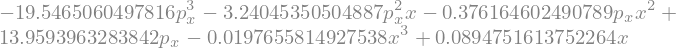

In [963]:
coord = [x,px]
lie_f2 = DF[0][:2,:2]
lie_f3 = LieOperator(-DF[1].subs(inv_track_rep),[x], [px])
lie_f4 = LieOperator(-DF[2].subs(inv_track_rep),[x], [px])

vec = np.dot(lie_f2,coord)
truncate((lie_f4.LieMap((lie_f3.LieMap(vec[0],2)).expand(),2)).expand(),4)

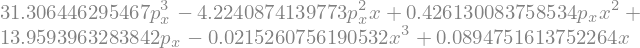

In [964]:
truncatexpx(x5,3).subs(inv_track_rep)

In [965]:
lrept = [(x,(Matrix(DF[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[0]),(px,(Matrix(DF[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[1])]
lrept

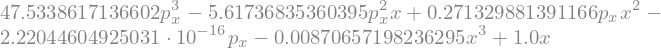

In [966]:
truncate((lie_f4.LieMap((lie_f3.LieMap(vec[0],2)).expand(),2)).expand(),4).subs(inv_track_rep).subs(lrept).subs(inv_track_rep).expand()

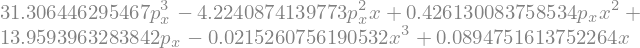

In [961]:
truncatexpx(x5,3).subs(inv_track_rep)

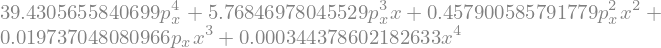

In [957]:
DF[2].subs(lrep).expand().subs(inv_track_rep)

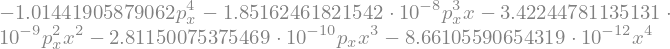

In [945]:
DFS[2].subs(lrep).expand().subs(inv_track_rep)

In [ ]:
func = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep))
func2 = lambdify((x,px),DF[2].subs(lrept).expand().subs(inv_track_rep))

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 100
prange = .15
npoints= 800

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func(Xg,Pg),func2(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
plt.colorbar(cb)

## Symplectic Taylor

In [1067]:
DFS = dragt_finn_factorization(
    [
        xx5_expr, 
        px5_expr,
        y,
        py,
        z,
        delta]
    ,
    [x,px,y,py,z,delta]
)

2021-03-20 19:47:24,714 - root -INFO - Starting dragt-finn factorization.
2021-03-20 19:47:24,722 - root -INFO - Taylor in
2021-03-20 19:47:24,724 - root -INFO - [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-20 19:47:24,731 - root -INFO - Transforming Taylor to Lie.
2021-03-20 19:47:24,732 - root -INFO - [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-20 19:47:24,738 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
2021-03-20 19:47:24,742 - root -INFO - Extracting linear transfer matrix from linear part of [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-20 19:47:24,752 - root -INFO - Cleaning up Taylor vector map.
[[ 1.00000000e+00 -8.51300000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.22680000e-03  1.0489994

100%|██████████| 3/3 [00:00<00:00, 2109.46it/s]


2021-03-20 19:47:24,844 - root -INFO - Taylor out
2021-03-20 19:47:24,845 - root -INFO - [-3.57947720118434*p_x**3 + 0.0131739078912386*p_x**2*x - 1.61617502009711e-5*p_x*x**2 + 6.60907838218363e-9*x**3, 0.020602893293923*p_x**3 - 7.58268884789526e-5*p_x**2*x + 9.3024426785977e-8*p_x*x**2 - 3.80407889270113e-11*x**3, 0, 0, 0, 0]
2021-03-20 19:47:24,852 - root -INFO - Taylor in
2021-03-20 19:47:24,853 - root -INFO - [-3.57947720118434*p_x**3 + 0.0131739078912386*p_x**2*x - 1.61617502009711e-5*p_x*x**2 + 6.60907838218363e-9*x**3, 0.020602893293923*p_x**3 - 7.58268884789526e-5*p_x**2*x + 9.3024426785977e-8*p_x*x**2 - 3.80407889270113e-11*x**3, 0, 0, 0, 0]
2021-03-20 19:47:24,859 - root -INFO - Transforming Taylor to Lie.
2021-03-20 19:47:24,860 - root -INFO - [-3.57947720118434*p_x**3 + 0.0131739078912386*p_x**2*x - 1.61617502009711e-5*p_x*x**2 + 6.60907838218363e-9*x**3, 0.020602893293923*p_x**3 - 7.58268884789526e-5*p_x**2*x + 9.3024426785977e-8*p_x*x**2 - 3.80407889270113e-11*x**3, 0, 

100%|██████████| 3/3 [00:00<00:00, 26.75it/s]


2021-03-20 19:47:25,260 - root -INFO - Taylor out
2021-03-20 19:47:25,261 - root -INFO - [1.73472347597681e-18*p_x**2*x - x, 0.0249941959243359*p_x**3 - 9.19886386799237e-5*p_x**2*x + 1.12851661932528e-7*p_x*x**2 - p_x, -y, -p_y, -z, -delta]


In [1008]:
xx5_expr, px5_expr

In [1005]:
px5_expr

In [1068]:
coord = [x,px]
lie_f2 = DFS[0]
lie_f3 = LieOperator(-DFS[1].subs(inv_track_rep),[x], [px])
lie_f4 = LieOperator(-DFS[2].subs(inv_track_rep),[x], [px])
# lie_f5 = LieOperator(-DFS[3].subs(inv_track_rep),[x], [px])
# lie_f6 = LieOperator(-DFS[4].subs(inv_track_rep),[x], [px])

In [1024]:
lrep

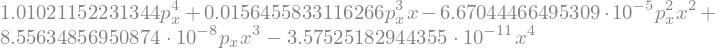

In [1028]:
lie_f4.ham.subs(lrep).expand().subs(inv_track_rep)

In [1012]:
vec = np.dot(lie_f2[:2,:2],coord)
truncate(lie_f4.LieMap(lie_f3.LieMap(vec[0],1).expand(),1),4)

In [1016]:
vec = np.dot(lie_f2[:2,:2],coord)
truncate(lie_f4.LieMap(lie_f3.LieMap(vec[1],1).expand(),1),4)

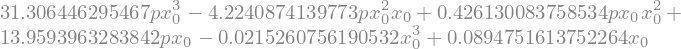

In [1021]:
truncatexpx(x5,4)

In [1014]:
lie_f3.LieMap(vec[0],1).expand().ham

In [1015]:
DFS[2]

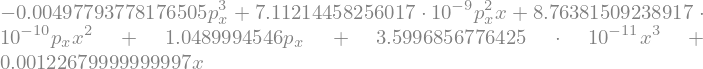

In [802]:
truncate(lie_f4.LieMap(lie_f3.LieMap(vec[1],1).expand(),1),4)

In [780]:
vec[0], vec[1]

In [781]:
xx5_expr,px5_expr

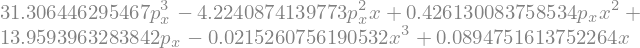

In [698]:
truncatexpx(x5,4).subs(inv_track_rep)

In [673]:
taylor = [x5.subs(inv_track_rep).expand(),px5.subs(inv_track_rep).expand()]
degree = 4

In [721]:
xx5_expr

In [767]:
lrep = [(x,(Matrix(DFS[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[0]),(px,(Matrix(DFS[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[1])]
lrep

In [987]:
taylor = [xx5_expr,px5_expr]
degree = 4

In [988]:
from functools import reduce
import operator

def prod(iterable):
    """
    akin to built - in sum() but for product
    """
    return reduce(operator.mul, iterable, 1)


_epstemp = symbols("e")

# immutable variable tuple
variables = tuple([x,px,y,py,z,delta])

# immutable tuple to track the sorting order of the various derivatives
derivatives = (1, 0, 3, 2, 5, 4)  # order: d/dpx, d/dx, d/dpy, d/dy, d/dz, d/dz
f = poly(0,*variables)  # Lie 

for var, polynomial in enumerate(taylor):
        # make sympy polynomial from the polynomial
        p = poly(polynomial, *variables)  # sym_x, sym_px, sym_y, sym_py, sym_z, sym_pz)
        
        # generate an array of the monomial degrees
        order = [sum(mon) for mon in p.monoms()]
       
        for index, monomial in enumerate(p.monoms()):
            # check hom level -> derivative is order - 1
            if order[index] == (degree - 1):
    
                # reconstruct monomial
                mon = prod(a ** b for a, b in zip(variables, monomial))
            
                print(mon)
                print(f)

                 # avoid double sum of same coeff
                if (f.coeff_monomial(mon * variables[derivatives[var]])) == 0:
                    # normalize derivative power
                    power = monomial[derivatives[var]]
                    print(power)
                    f = f + (p.coeffs()[index] / (power + 1.)) * mon * variables[derivatives[var]] * (-1) ** (var)
                    
f.as_expr()

p_x**3
Poly(0, x, p_x, y, p_y, z, delta, domain='ZZ')
3
p_x**3
Poly(-1.064125*p_x**4, x, p_x, y, p_y, z, delta, domain='RR')
0


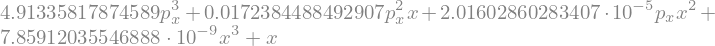

In [996]:
LieOperator(DFS[2],[x],[px]).LieMap(x,1).ham

In [989]:
f.as_expr()

In [994]:
LieOperator(f.as_expr(),[x],[px]).LieMap(x,1).ham

In [978]:
xx5_expr

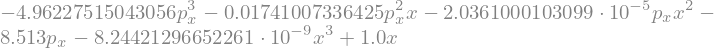

In [1000]:
vec = np.dot(lie_f2[:2,:2],coord)
truncate(lie_f4.LieMap(lie_f3.LieMap(vec[0],1).expand(),1),4)

In [1004]:
poly_x = 1.0*x + x**2 + 2* x*px + px**2 +x**3 + x**2 *px + 2*x*px**2 + px**3
poly_p = px + x**2 - 2* x*px - px**2 +x**3 + 5*x**2 *px + 3*x*px**2 - Rational(2,3)* px**3
taylor_vector = [poly_x,poly_p]

In [1002]:
poly_x

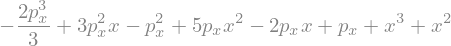

In [1003]:
poly_p

In [645]:
F[2]

In [648]:
coord = [x,px]
lie_f2 = F[0][:2,:2]
lie_f3 = LieOperator(-F[1].subs(inv_track_rep),[x], [px])
lie_f4 = LieOperator(-F[2].subs(inv_track_rep),[x], [px])


In [649]:
vec = np.dot(lie_f2,coord)

In [650]:
truncate((lie_f4.LieMap((lie_f3.LieMap(vec[0],2)).expand(),2)).expand(),4)

100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


In [651]:
truncate((lie_f4.LieMap((lie_f3.LieMap(vec[1],2)).expand(),2)).expand(),4)

100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


In [642]:
F = dragt_finn_factorization(
    [
        poly_x, 
        poly_p,
        y,
        py,
        z,
        delta]
    ,
    [x,px,y,py,z,delta]
)

2021-03-20 15:50:32,924 - root -INFO - Starting dragt-finn factorization.
2021-03-20 15:50:32,931 - root -INFO - Transforming Taylor to Lie.
2021-03-20 15:50:32,932 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
2021-03-20 15:50:32,939 - root -INFO - Extracting linear transfer matrix from linear part of [p_x**3 + 2*p_x**2*x + p_x**2 + p_x*x**2 + 2*p_x*x + x**3 + x**2 + 1.0*x, -2*p_x**3/3 + 3*p_x**2*x - p_x**2 + 5*p_x*x**2 - 2*p_x*x + p_x + x**3 + x**2, y, p_y, z, delta]
2021-03-20 15:50:32,950 - root -INFO - Cleaning up Taylor vector map.
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
2021-03-20 15:50:33,030 - root -INFO - Transforming Taylor to Lie.
2021-03-20 15:50:33,031 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
Poly(1.0*x**2*p_x, x, p_x, y, p_y, z, delta, domain='RR')
Poly(1.0*x**2*p_x + 1.0*x*p_x**2, x, p_x, y, p_y, z, delta, domain='RR')
Poly(1.0*x**2*p_x + 1.0*x*p_x**2 + 0.3333333333

100%|██████████| 3/3 [00:00<00:00, 246.79it/s]

100%|██████████| 3/3 [00:00<00:00, 224.50it/s]

100%|██████████| 3/3 [00:00<00:00, 16.79it/s]


2021-03-20 15:50:33,463 - root -INFO - Transforming Taylor to Lie.
2021-03-20 15:50:33,464 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
Poly(-1.0*x**3*p_x, x, p_x, y, p_y, z, delta, domain='RR')
Poly(-1.0*x**3*p_x - 0.5*x**2*p_x**2, x, p_x, y, p_y, z, delta, domain='RR')
Poly(-1.0*x**3*p_x - 0.5*x**2*p_x**2 + 0.666666666666667*x*p_x**3, x, p_x, y, p_y, z, delta, domain='RR')
Poly(-1.0*x**3*p_x - 0.5*x**2*p_x**2 + 0.666666666666667*x*p_x**3 + 0.25*p_x**4, x, p_x, y, p_y, z, delta, domain='RR')
Poly(-0.25*x**4 - 1.0*x**3*p_x - 0.5*x**2*p_x**2 + 0.666666666666667*x*p_x**3 + 0.25*p_x**4, x, p_x, y, p_y, z, delta, domain='RR')
2021-03-20 15:50:33,493 - root -INFO - Cleaning up Taylor vector map.
2021-03-20 15:50:33,495 - root -WARNING - coords used - [x, y, z], phases used - [p_x, p_y, delta]


100%|██████████| 3/3 [00:00<00:00, 172.04it/s]

100%|██████████| 3/3 [00:00<00:00, 222.08it/s]

100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


100%|██████████| 400/400 [00:00<00:00, 9750.57it/s]


<IPython.core.display.Javascript object>


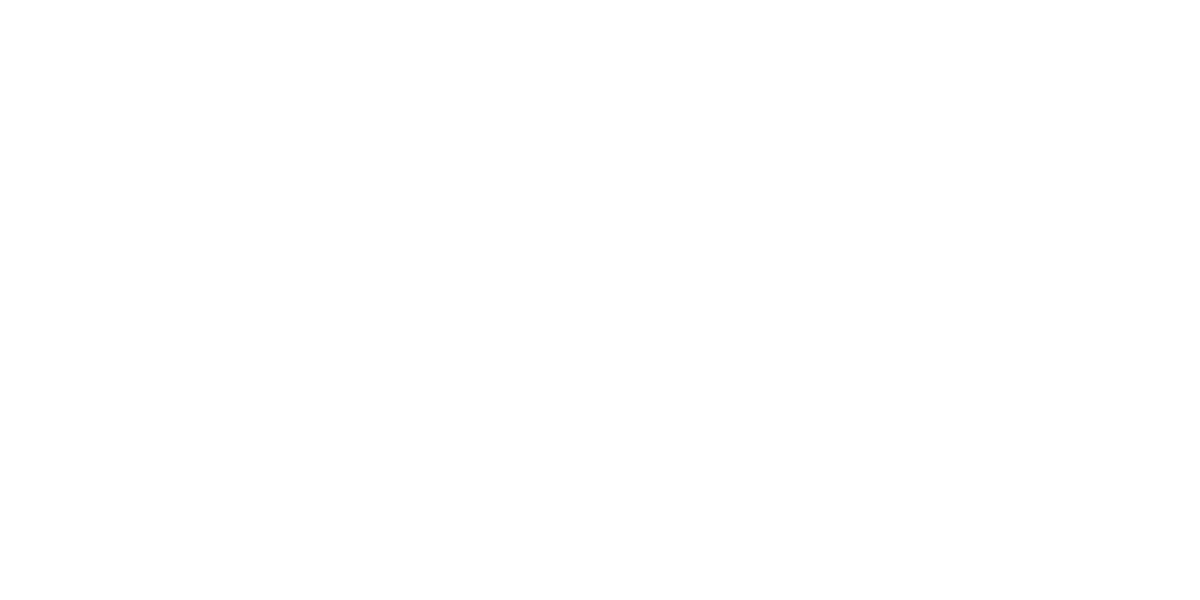

In [390]:
X_ElByEl_2_4_2 = np.array([r0])
duration = 400

for i in tqdm(range(1, duration + 1)): 
#     r_2 = track(X_ElByEl_2_4_2[-1],ffxt2,ffpxt2)
    r_2 = track_symplectic(X_ElByEl_2_4_2[-1])
    
    X_ElByEl_2_4_2 = np.append(X_ElByEl_2_4_2, [r_2], axis = 0)
    
X_ElByEl_2_4_2_array = np.array(X_ElByEl_2_4_2)
New_FIG(X_ElByEl_2_4_2_array[:,:,0],X_ElByEl_2_4_2_array[:,:,1],X_ElByEl_2_4_2_array[:,:,2],X_ElByEl_2_4_2_array[:,:,3])

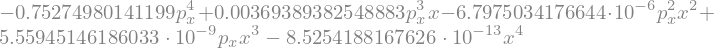

In [446]:
DF[2]

In [447]:
xx5_expr

In [448]:
px5_expr

In [453]:
solve(xx5_expr,x,px)[0][0].expand()

In [454]:
solve(px5_expr,x,px)[0][0].expand()

<IPython.core.display.Javascript object>


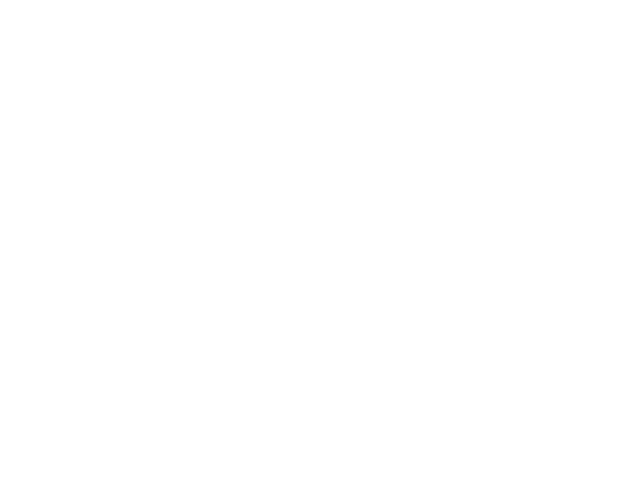

In [458]:
plt.figure()
plt.plot(X,lambdify(px,solve(xx5_expr,x,px)[0][0].expand())(X))
plt.plot(X,lambdify(px,solve(px5_expr,x,px)[0][0].expand())(X))

In [305]:
dq_dt(r0[:,0],r0[:,1])

ValueError: too many values to unpack (expected 1)

In [306]:
_apply_func(dq_dt[0],r0[:,0],r0[:,1])

TypeError: 'function' object is not subscriptable

In [35]:
tic = time.perf_counter()
# QF
x1  = taylor_qf2_x.subs(track_rep).subs(rept).expand()
px1 = taylor_qf2_px.subs(track_rep).subs(rept).expand()

# QF - D
x2  = taylor_d4_x.subs(list(zip([x,px],[x1,px1]))).subs(rept).expand()
px2 = taylor_d4_px.subs(list(zip([x,px],[x1,px1]))).subs(rept).expand()

# QF - D - QD 
x3  = taylor_qd2_x.subs(list(zip([x,px],[x2,px2]))).subs(rept).expand()
px3 = taylor_qd2_px.subs(list(zip([x,px],[x2,px2]))).subs(rept).expand()

# QF - D - QD - D
x4  = taylor_d4_x.subs(list(zip([x,px],[x3,px3]))).subs(rept).expand()
px4 = taylor_d4_px.subs(list(zip([x,px],[x3,px3]))).subs(rept).expand()

# QF - D - QD - D - QF
x5  = taylor_qf2_x.subs(list(zip([x,px],[x4,px4]))).subs(rept).expand()
px5 = taylor_qf2_px.subs(list(zip([x,px],[x4,px4]))).subs(rept).expand()


In [157]:
HQF2_op.ham

In [278]:
it = integrator(HQF2_op.ham,[x],[px],order=1)

here


In [249]:
it.single_step_func

<function acchamiltoniansandmatrices.Integrators.integrators.SymplecticIntegrator._create_single_step_func.<locals>.single_step_func(q_curr, p_curr, dt)>

In [279]:
it.single_step_func(np.array([1]),np.array([2]),1)

here
[1]
[2]
here
[1]
[2]
[1]
[2]
[[-0.684]]
[[0.16758]]


(array([[0.316]]), array([[2.05295528]]))

In [281]:
it.evolve(np.array([1]),np.array([0]),range(5))

iter
iter [1] [0]
here
[1]
[0]
here
[1]
[0]
[1]
[0]
[[-0.]]
[[0.16758]]
iter [[1.]] [[0.16758]]
here
[[1.]]
[[0.16758]]
here
[[1.]]
[[0.16758]]
[[1.]]
[[0.16758]]
[[-0.05731236]]
[[0.16758]]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [193]:
f1,f2 = it._equations_of_motion()

In [196]:
f1(np.array([1]),np.array([2]))

array([[-0.684]])

In [199]:
np.diff([0,1.5,3.5])

array([1.5, 2. ])

In [201]:
list(it.evolve_iter(r0[:2,0],r0[:2,1],[0,1]))

ValueError: too many values to unpack (expected 1)

In [227]:
np.split(np.concatenate([np.array([1]),np.array([0])],axis=0),2,axis=0)

[array([1]), array([0])]

In [207]:
r0[:2,0]

array([1.e-06, 1.e-06])

In [219]:
f2(*np.split(np.concatenate([r0[10:11,0],r0[:1,1]],axis=0),2,axis=0))

array([[0.058653]])

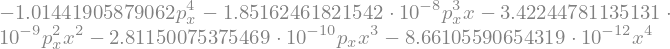

In [821]:
DFS[2].subs(lrep).expand().subs(inv_track_rep)

<IPython.core.display.Javascript object>


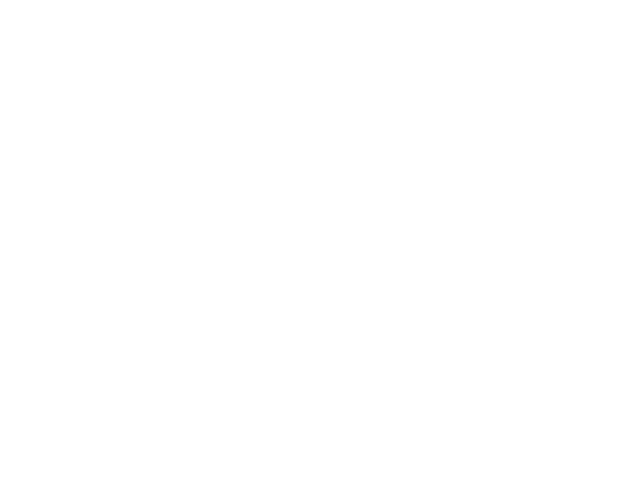

In [877]:
plt.figure()
# plt.plot(X,func2(X,0.8)+0.0000001*X**2)
plt.plot(X,func2(X,0.07)+0.0000001*X**2+0.01*0.07**2)
# plt.plot(X,func2(X,0.11)+0.0000001*X**2)

In [878]:
lrept = [(x,(Matrix(DF[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[0]),(px,(Matrix(DF[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[1])]
lrept

<IPython.core.display.Javascript object>


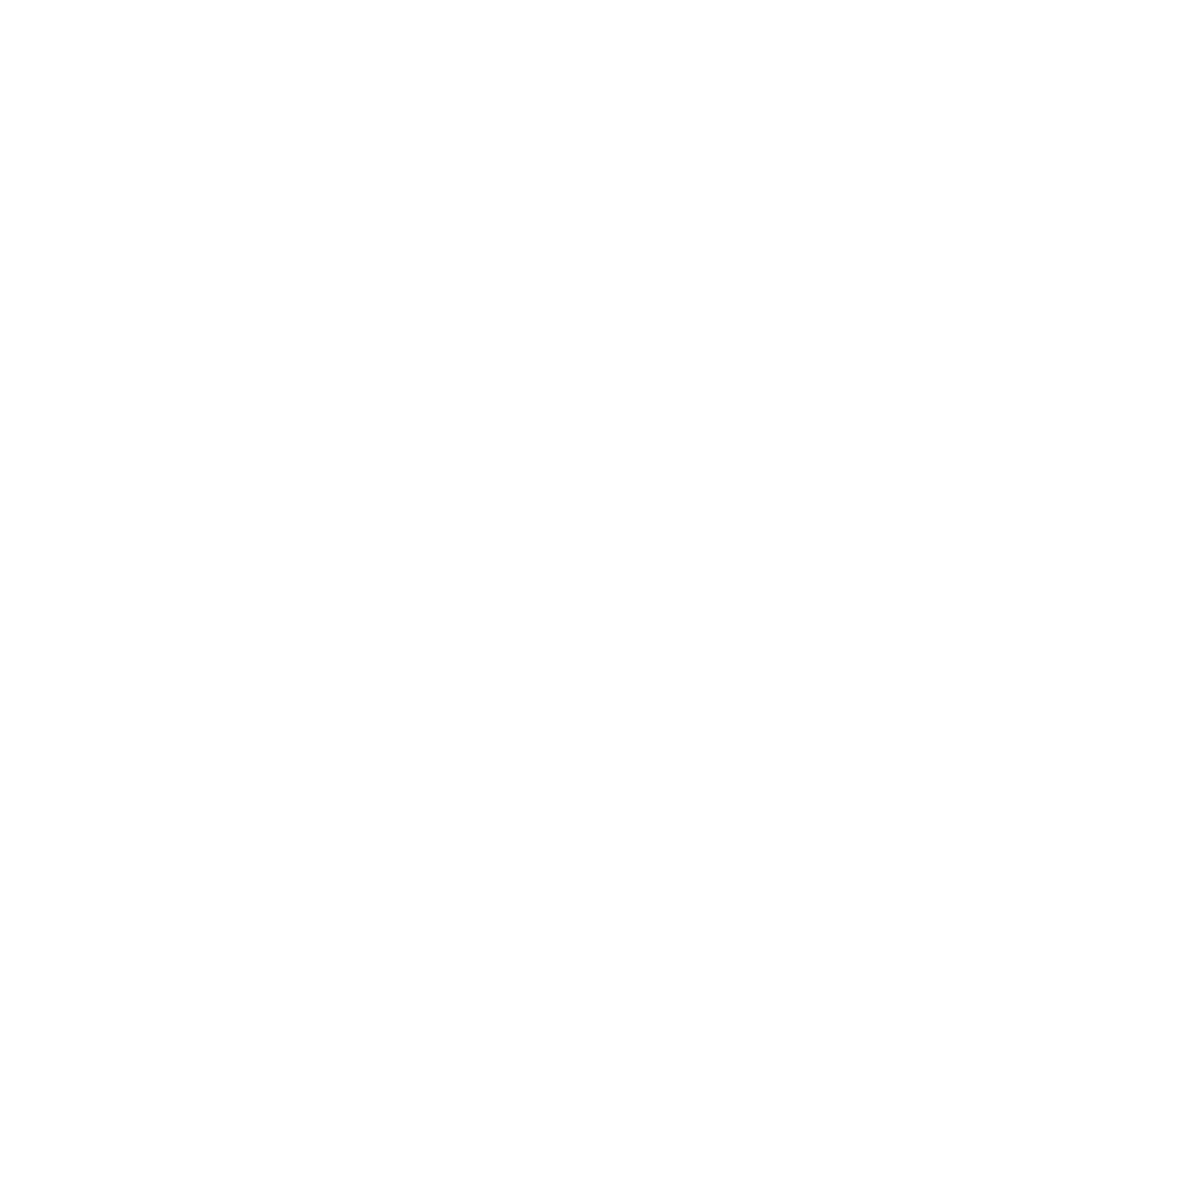

In [900]:
func = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep))
func2 = lambdify((x,px),DF[2].subs(lrept).expand().subs(inv_track_rep))

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 100
prange = .15
npoints= 800

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func(Xg,Pg),func2(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
plt.colorbar(cb)

In [1033]:
DFS[0]

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

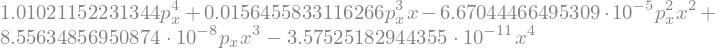

In [1031]:
lie_f4.ham.subs(lrep).expand().subs(inv_track_rep)

<IPython.core.display.Javascript object>


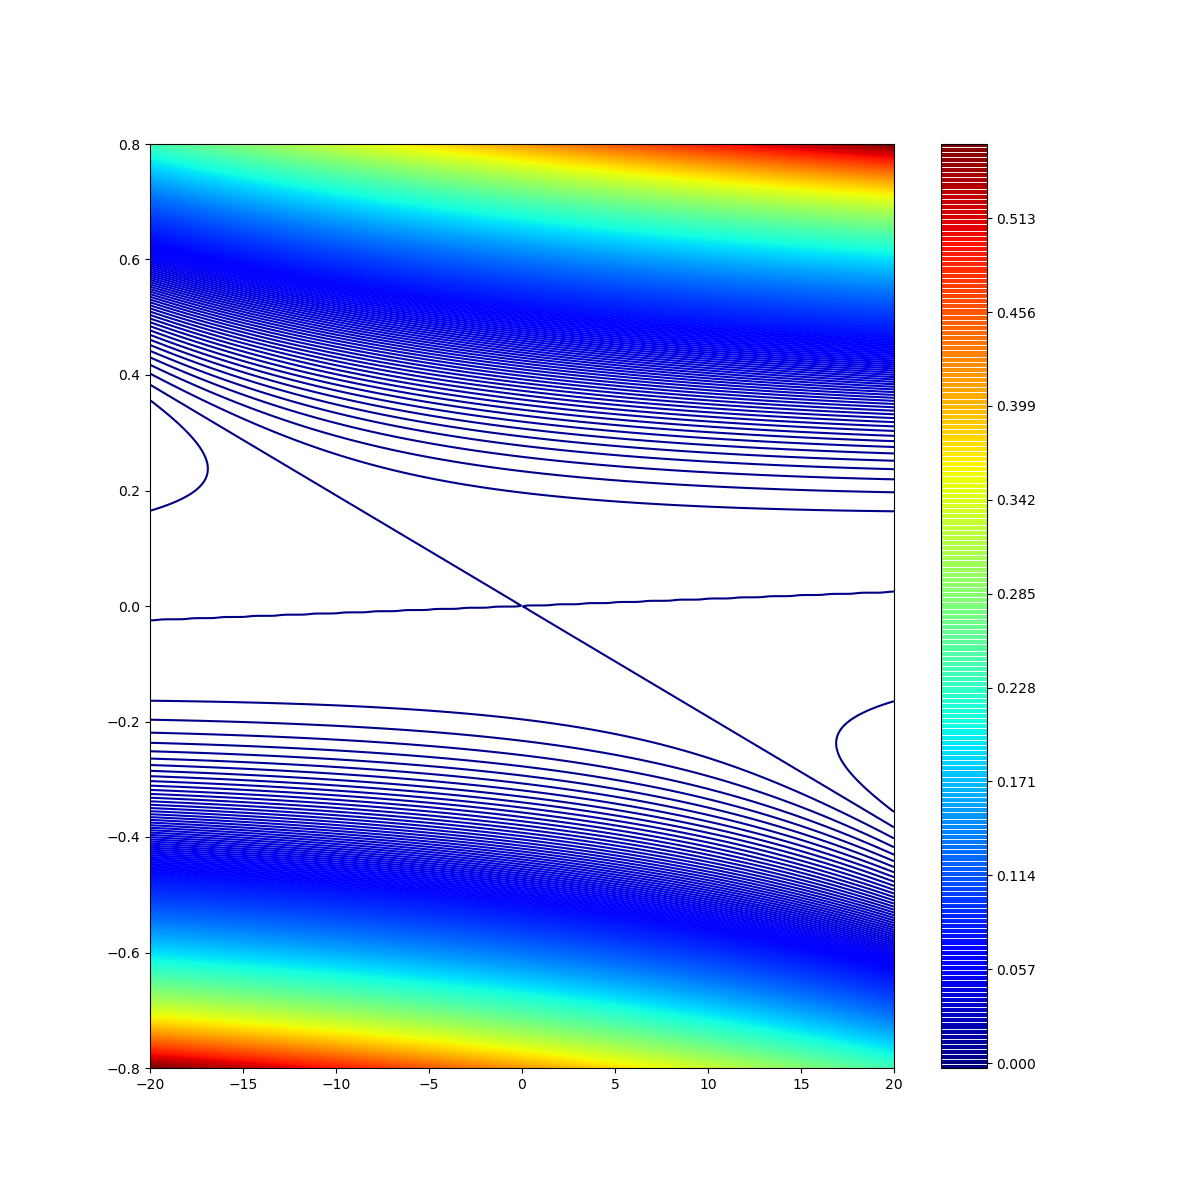

In [1030]:
lie_f4.ham.subs(lrep).expand().subs(inv_track_rep)
func = lambdify((x,px),lie_f4.ham.subs(lrep).expand().subs(inv_track_rep))
func2 = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep))

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 20
prange = .8
npoints= 800

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func(Xg,Pg),func2(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
plt.colorbar(cb)

<IPython.core.display.Javascript object>


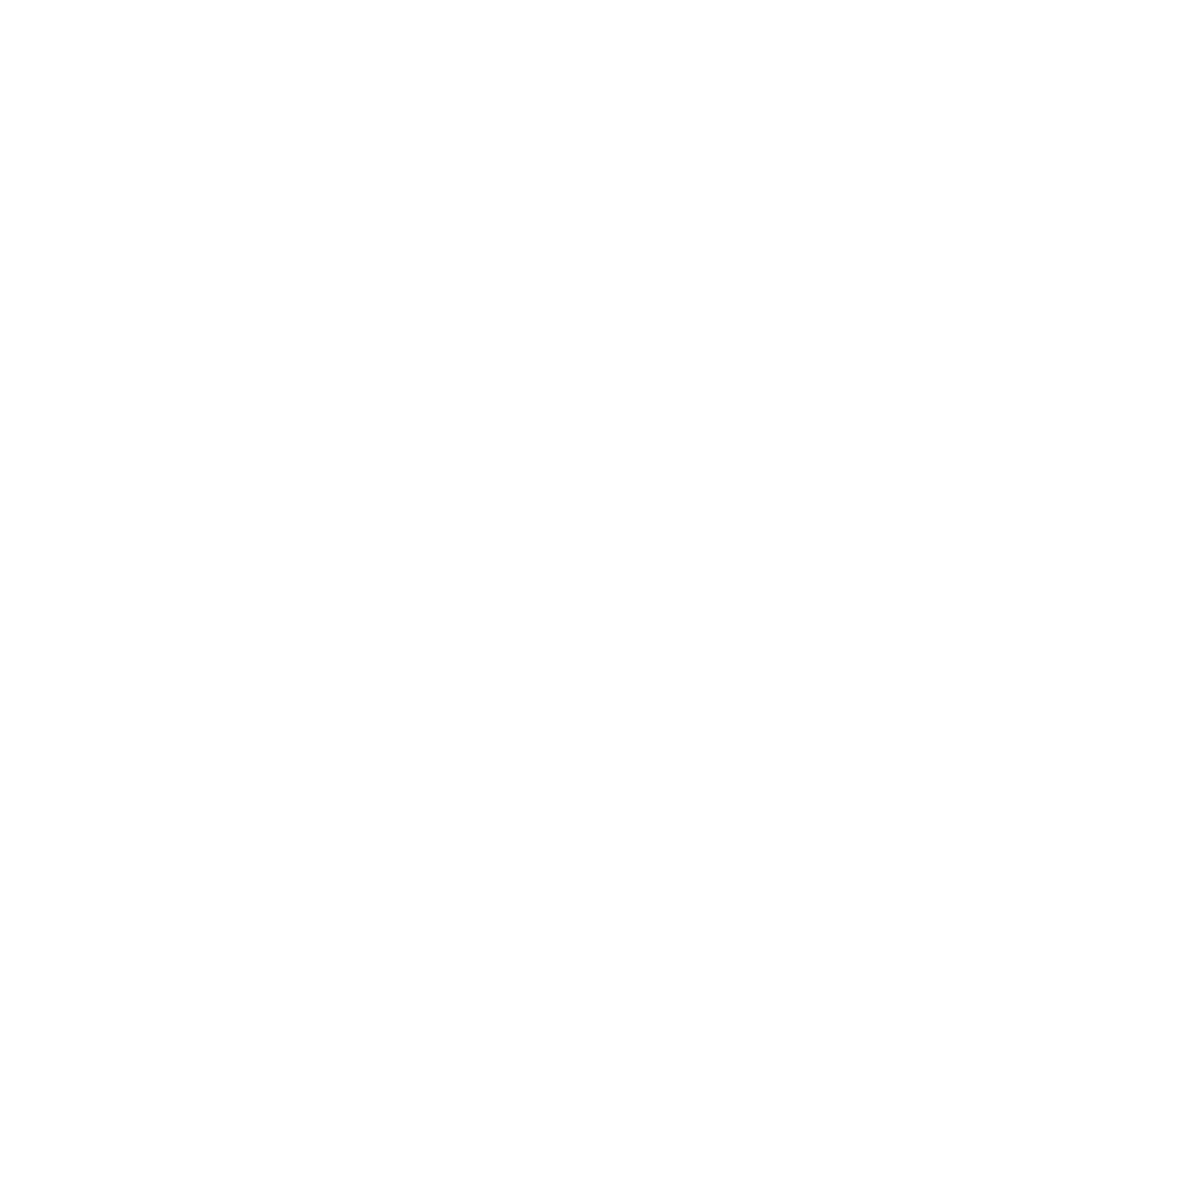

In [858]:
func = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep)+0.0000001*x**2+0.01*px**2)
func2 = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep))

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 200
prange = .2
npoints= 800

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func(Xg,Pg),func2(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
plt.colorbar(cb)

<IPython.core.display.Javascript object>


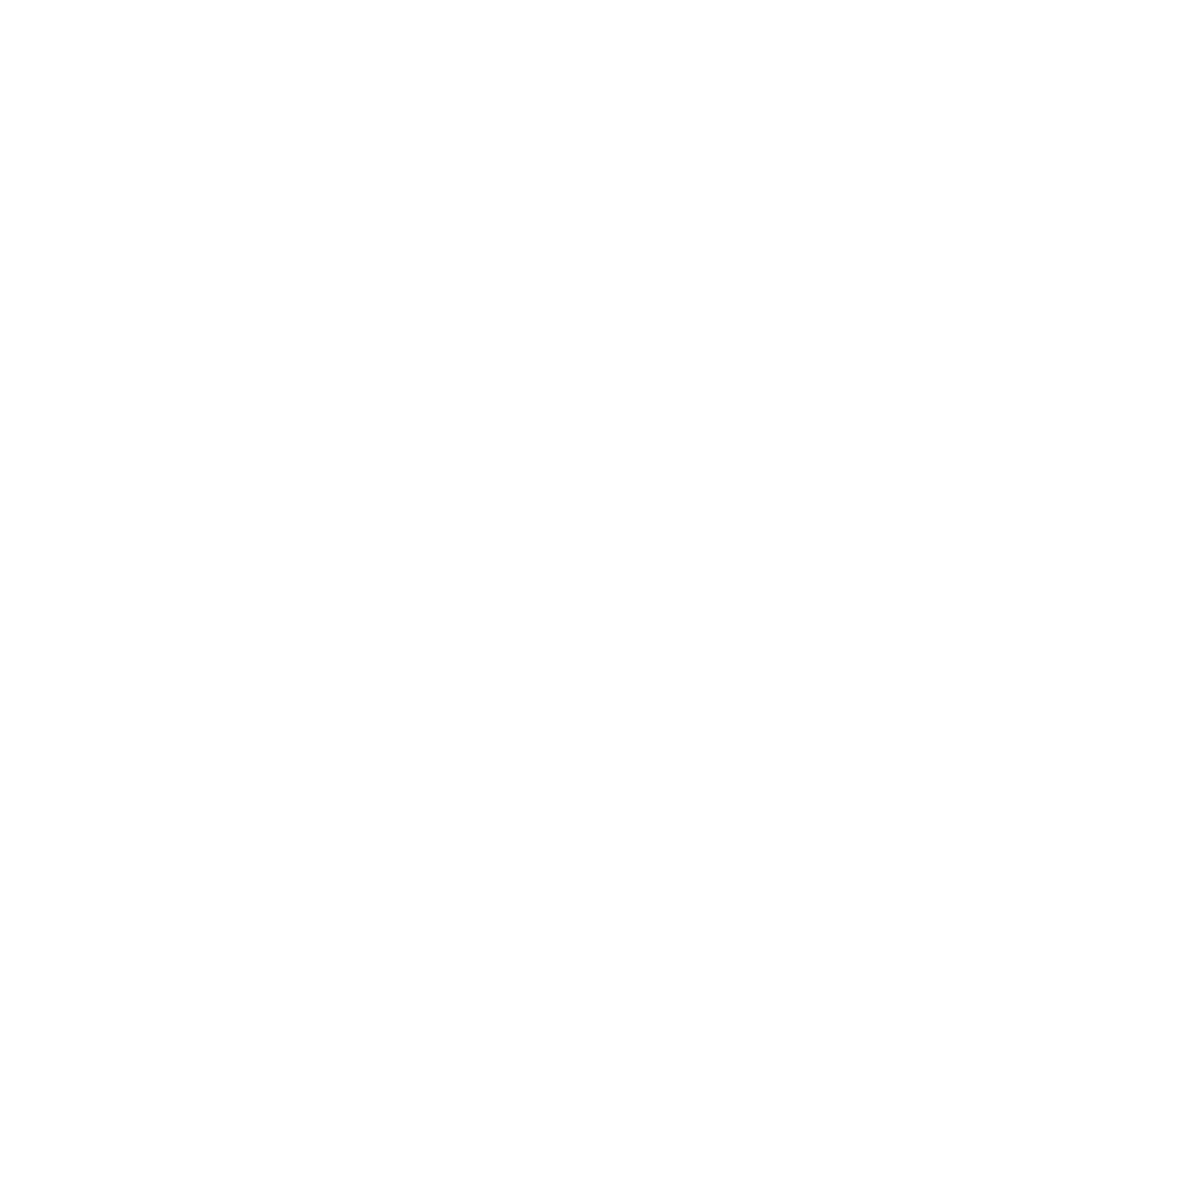

In [857]:
func = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep)+0.000000000025*x**2+0.01*px**2)
func2 = lambdify((x,px),DFS[2])

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 5
prange = .0704
npoints= 800

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(0.0701, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func(Xg,Pg),func2(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=400,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
plt.colorbar(cb)


In [1045]:
f2 = Function("f_2", commutative=False)(x,px)
f4 = Function("f_4", commutative=False)(x,px)

A , B = symbols("A B")

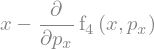

In [1046]:
LieOperator(f4,[x],[px]).LieMap(x,1).ham

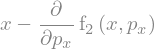

In [1059]:
LieOperator(f2,[x],[px]).LieMap(x,1).ham

In [1047]:
print_latex(LieOperator(f2,[x],[px]).LieMap(LieOperator(f4,[x],[px]).LieMap(px,1).ham,1).ham)

p_{x} + \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial}{\partial x} \operatorname{f_{4}}{\left(x,p_{x} \right)} - \frac{\partial^{2}}{\partial x^{2}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial p_{x}} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial^{2}}{\partial x\partial p_{x}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)}


$$
x_1 = x - \frac{\partial}{\partial p_{x}} \operatorname{f_{2}}{\left(x,p_{x} \right)} - \frac{\partial}{\partial p_{x}} \operatorname{f_{4}}{\left(x,p_{x} \right)} - \frac{\partial^{2}}{\partial p_{x}^{2}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial^{2}}{\partial x\partial p_{x}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial p_{x}} \operatorname{f_{2}}{\left(x,p_{x} \right)} \\
px_1 = p_{x} + \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial}{\partial x} \operatorname{f_{4}}{\left(x,p_{x} \right)} - \frac{\partial^{2}}{\partial x^{2}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial p_{x}} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial^{2}}{\partial x\partial p_{x}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)}
$$

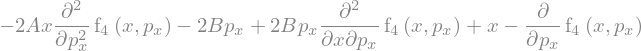

In [1056]:
LieOperator(f2,[x],[px]).LieMap(LieOperator(f4,[x],[px]).LieMap(x,1).ham,1).ham.subs(f2,A*x**2+B*px**2).doit()

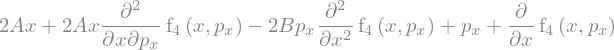

In [1057]:
LieOperator(f2,[x],[px]).LieMap(LieOperator(f4,[x],[px]).LieMap(px,1).ham,1).ham.subs(f2,A*x**2+B*px**2).doit()

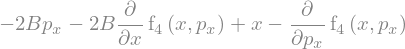

In [1058]:
LieOperator(f4,[x],[px]).LieMap(LieOperator(f2,[x],[px]).LieMap(x,1).ham,1).ham.subs(f2,A*x**2+B*px**2).doit()

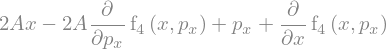

In [1060]:
LieOperator(f4,[x],[px]).LieMap(LieOperator(f2,[x],[px]).LieMap(px,1).ham,1).ham.subs(f2,A*x**2+B*px**2).doit()

In [1061]:
xx5_expr

In [1062]:
px5_expr

In [1064]:
AA = px5_expr.coeff(x)/2.
BB = xx5_expr.coeff(px)/2.
AA,BB

In [1070]:
DFS[0][:2,:2]

array([[ 1.00000000e+00, -8.51300000e+00],
       [ 1.22680000e-03,  1.04899945e+00]])

In [1073]:
LieOperator(AA*x**2+BB*px**2,[x],[px]).LieMap(x,1).ham

In [1074]:
LieOperator(AA*x**2+BB*px**2,[x],[px]).LieMap(px,1).ham

In [1075]:
2*AA*BB*2